In [69]:
#Etape de ML avec XGBOOST et RANDOM FOREST

# Dans ce notebook, nous allons :
#- Charger les données historiques issues de la base `bitcoin_data` (ou CSV),
#- Les agréger à différents intervalles (jours, semaines, mois),
#- Ajouter les indicateurs techniques nécessaires au Machine Learning,
#- Créer la variable cible (`shift_close`),
#- Évaluer plusieurs modèles de régression (Random Forest, XGBoost),
#- Sauvegarder le modèle pour la mise en production (étape 4).


In [70]:
# ## 1. Importation des librairies
# Importation des packages nécessaires


import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from ta.trend import EMAIndicator
from ta.trend import MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.trend import ADXIndicator
from ta.volume import MFIIndicator
import plotly.express as px
import nbformat
import plotly.graph_objects as go
import seaborn as sns
import ta
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings
warnings.filterwarnings("ignore")




In [71]:
# ## 2 Chargement des différents fichiers exportés (chaque CSV correspond à une partie du dataset)
df0 = pd.read_csv('../data/btc_prices_part_0.csv', sep="\t")
df1 = pd.read_csv('../data/btc_prices_part_1.csv', sep="\t")
df2 = pd.read_csv('../data/btc_prices_part_2.csv', sep="\t")
df3 = pd.read_csv('../data/btc_prices_part_3.csv', sep="\t")

# Fusion en un seul DataFrame
df = pd.concat([df0, df1, df2, df3], ignore_index=True)

# Conversion du champ 'date' en datetime
df["date"] = pd.to_datetime(df["date"])

# Tri chronologique (toujours préférable avant le ML)
df = df.sort_values("date").reset_index(drop=True)

print(f"Données chargées avec succès : {df.shape[0]} lignes, {df.shape[1]} colonnes")
display(df.head())

Données chargées avec succès : 3429650 lignes, 6 colonnes


,date,open,high,low,close,volume
0,2018-12-15 04:11:00,3200.00,3200.00,3200.00,3200.00,0.003
1,2018-12-15 04:12:00,3000.00,3312.32,3000.00,3312.32,1.882
2,2018-12-15 04:13:00,3312.32,3312.32,3312.32,3312.32,0.000
3,2018-12-15 04:14:00,3312.32,3312.32,3312.32,3312.32,0.000
4,2018-12-15 04:15:00,3312.32,3312.32,3312.32,3312.32,0.000


Les données historiques du Bitcoin ont été extraites via l’API Binance, puis exportées en plusieurs fichiers CSV pour des raisons de taille.  
Cette cellule regroupe les fichiers et convertit les dates au bon format pour l’analyse temporelle.

In [72]:
# ## 3. Configuration des paramètres
# Définition des intervalles temporels et des colonnes associées

time_config = {
    'minutes': {
        'interval': '1m',  # Fréquence pandas pour le rééchantillonnage
        'table': 'btc_prices_minutes',
        'columns': ['date', 'open', 'high', 'low', 'close', 'volume', 'minute']
    },
    'heures': {
        'interval': '1h',
        'table': 'btc_prices_hours',
        'columns': ['date', 'open', 'high', 'low', 'close', 'volume', 'hour']
    },
    'jours': {
        'interval': '1d',
        'table': 'btc_prices_days',
        'columns': ['date', 'open', 'high', 'low', 'close', 'volume']
    },
    'mois': {
        'interval': '1M',
        'table': 'btc_prices_months',
        'columns': ['date', 'open', 'high', 'low', 'close', 'volume', 'month']
    },
    'années': {
        'interval': '1y',
        'table': 'btc_prices_years',
        'columns': ['date', 'open', 'high', 'low', 'close', 'volume', 'year']
    }
}

In [73]:
# ## 4 - Fonction d'agrégation optimisée avec KPI (indicateurs techniques)

import ta

def aggregate_with_kpi(df, time_unit):
    """
    Agrège les données BTC et calcule les indicateurs techniques nécessaires au Machine Learning.
    
    Args:
        df: DataFrame avec colonnes ['date', 'open', 'high', 'low', 'close', 'volume']
        time_unit: 'heures', 'jours', 'mois', 'années'
    
    Returns:
        DataFrame agrégé avec indicateurs (EMA, MACD, RSI, Bollinger, etc.) + cible (shift_close)
    """

    # Configuration des intervalles temporels
    config = {
        'heures': ('1H', 'hour'),
        'jours': ('1D', 'day'),
        'mois': ('1M', 'month'),
        'années': ('1Y', 'year')
    }.get(time_unit)

    if not config:
        raise ValueError(f"Unité temporelle non valide : {time_unit}")

    interval, time_col = config

    # Décomposition des dates pour plus de flexibilité
    df['Year'] = df['date'].dt.year
    df['Month'] = df['date'].dt.month
    df['Day'] = df['date'].dt.day
    df['Hour'] = df['date'].dt.hour
    df['Minute'] = df['date'].dt.minute

    # Agrégation temporelle
    df_grouped = (
        df.set_index('date')
          .resample(interval)
          .agg({
              'open': 'first',
              'high': 'max',
              'low': 'min',
              'close': 'last',
              'volume': 'sum'
          })
          .dropna()
          .reset_index()
    )

    # Calcul des indicateurs techniques (KPI)
    df_grouped["ema_7"] = ta.trend.ema_indicator(df_grouped["close"], window=7)
    df_grouped["ema_20"] = ta.trend.ema_indicator(df_grouped["close"], window=20)
    df_grouped["ema_99"] = ta.trend.ema_indicator(df_grouped["close"], window=99)

    macd_indicator = ta.trend.MACD(df_grouped["close"])
    df_grouped["macd"] = macd_indicator.macd()
    df_grouped["macd_signal"] = macd_indicator.macd_signal()

    df_grouped["rsi"] = ta.momentum.rsi(df_grouped["close"], window=14)

    boll = ta.volatility.BollingerBands(df_grouped["close"], window=20, window_dev=2)
    df_grouped["boll_b"] = boll.bollinger_pband()

    df_grouped["stoch_rsi"] = ta.momentum.stochrsi(df_grouped["close"], window=14, smooth1=3, smooth2=3)
    df_grouped["volume_ma20"] = df_grouped["volume"].rolling(window=20).mean()

    df_grouped["body_size"] = df_grouped["close"] - df_grouped["open"]
    df_grouped["upper_wick"] = df_grouped["high"] - df_grouped[["close", "open"]].max(axis=1)
    df_grouped["lower_wick"] = df_grouped[["close", "open"]].min(axis=1) - df_grouped["low"]

    df_grouped["pct_change_1"] = df_grouped["close"].pct_change(1)
    df_grouped["pct_change_3"] = df_grouped["close"].pct_change(3)
    df_grouped["pct_change_5"] = df_grouped["close"].pct_change(5)

    # Création de la colonne cible (target)
    df_grouped["shift_close"] = df_grouped["close"].shift(-1)

    # Nettoyage : suppression des premières lignes avec NaN
    df_grouped = df_grouped.iloc[26:].dropna().reset_index(drop=True)
    df_grouped["date"] = pd.to_datetime(df_grouped["date"])

    return df_grouped


La fonction `aggregate_with_kpi()` a pour but de regrouper les données en fonction de la période choisie 
(par heure, jour, mois ou année) et de calculer les principaux indicateurs techniques (EMA, MACD, RSI, Bollinger, etc.)
utiles à la modélisation Machine Learning.  
Elle crée également la colonne **shift_close**, qui servira de variable cible pour la prédiction du prix futur.


In [74]:
df_grouped = aggregate_with_kpi(df,"jours")

In [75]:
# ## 5 - Préparation des données pour le Machine Learning

# Liste des colonnes de prix à décaler pour créer des cibles futures
columns_to_shift = ['open', 'high', 'low', 'close', 'volume']

# Création des variables "shift" (valeurs du jour suivant)
for col in columns_to_shift:
    df_grouped[f'shift_{col}'] = df_grouped[col].shift(-1)

# Suppression des lignes contenant des valeurs manquantes (générées par le décalage)
df_grouped.dropna(inplace=True)

print("✅ Variables cibles créées :", [f"shift_{col}" for col in columns_to_shift])
df_grouped.head()



✅ Variables cibles créées : ['shift_open', 'shift_high', 'shift_low', 'shift_close', 'shift_volume']


,date,open,high,low,close,volume,ema_7,ema_20,ema_99,macd,...,upper_wick,lower_wick,pct_change_1,pct_change_3,pct_change_5,shift_close,shift_open,shift_high,shift_low,shift_volume
0,2019-03-23,3980.19,4000.00,3958.77,3970.48,495.987,3970.961849,3914.600757,3691.229239,59.467796,...,19.81,11.71,-0.002455,-0.015797,-0.001006,3967.00,3970.49,3982.00,3935.35,322.318
1,2019-03-24,3970.49,3982.00,3935.35,3967.00,322.318,3969.971387,3919.591161,3696.744654,56.464714,...,11.51,31.65,-0.000876,-0.001377,-0.006574,3903.12,3967.00,3981.20,3861.25,867.070
2,2019-03-25,3967.00,3981.20,3861.25,3903.12,867.070,3953.258540,3918.022479,3700.872161,48.372559,...,14.20,41.87,-0.016103,-0.019378,-0.032495,3913.93,3903.12,3923.48,3878.11,779.129
3,2019-03-26,3903.12,3923.48,3878.11,3913.93,779.129,3943.426405,3917.632719,3705.133318,42.343634,...,9.55,25.01,0.002770,-0.014243,-0.014736,4011.01,3913.93,4030.67,3909.34,815.479
4,2019-03-27,3913.93,4030.67,3909.34,4011.01,815.479,3960.322304,3926.525794,3711.250851,44.881842,...,19.66,4.59,0.024804,0.011094,0.007728,4008.08,4011.16,4033.97,3993.48,602.954


In [76]:
# ## 6. from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def prepare_data(df, target_col='shift_close', test_size=0.2, random_state=42):
    """
    Prépare les données pour le Machine Learning :
    - Crée des features temporelles
    - Sépare les données en train/test
    - Normalise les variables
    
    Args:
        df : DataFrame complet avec indicateurs techniques
        target_col : nom de la colonne cible à prédire (ex: 'shift_close')
        test_size : proportion du jeu de test
        random_state : graine aléatoire
    Returns:
        X_train, X_test, y_train, y_test, scaler, features
    """

    # --- 1. Création de variables temporelles ---
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_of_month'] = df['date'].dt.day
    df['week_of_year'] = df['date'].dt.isocalendar().week

    # --- 2. Sélection des features numériques ---
    features = df.drop(columns=['close'], errors='ignore').select_dtypes(include='number').columns.to_list()
    X = df[features]
    y = df[target_col]

    # --- 3. Séparation en train/test ---
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=False
    )

    # --- 4. Normalisation des données ---
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test, scaler, features


# Appel de la fonction
X_train, X_test, y_train, y_test, scaler, features = prepare_data(
    df_grouped, target_col='shift_close', test_size=0.2, random_state=42
)

print(f"✅ Données prêtes : {X_train.shape[0]} train / {X_test.shape[0]} test")

✅ Données prêtes : 1825 train / 457 test


In [77]:
X_train, X_test, y_train, y_test, scaler, features = prepare_data(df_grouped, target_col='shift_close', test_size=0.2, random_state=42)

RANDOM FOREST

In [78]:
# ## I. Random Forest avec Shift(CLOSE)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# 2. Trier par date
df = df_grouped

# 5. Supprimer les lignes avec des NaN dues aux shifts
df.dropna(inplace=True)

# 6. Séparer les features et la target
xcolumns1 = df_grouped.select_dtypes(include='number').columns.to_list()
X1 = df[xcolumns1].drop("close", axis = 1)
y1 = df['shift_close']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y1,train_size = 0.8, random_state = 42)

# 8. Entraîner le modèle Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X1_train, y1_train)
y1_test_pred = model.predict(X1_test)

# 9. Prédire et évaluer

mse1 = mean_squared_error(y1_test, y1_test_pred)
rmse1 = np.sqrt(mse1)
print(f"RMSE1: {rmse1:.2f}")


RMSE1: 108.22


In [79]:
# ## II. Random Forest avec Shift(OPEN)

# 2. Trier par date
df = df_grouped

# 5. Supprimer les lignes avec des NaN dues aux shifts
df.dropna(inplace=True)

# 6. Séparer les features et la target
xcolumns2 = df_grouped.select_dtypes(include='number').columns.to_list()
X2 = df[xcolumns2].drop("open", axis = 1)
y2 = df['shift_open']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2,train_size = 0.8, random_state = 42)

# 8. Entraîner le modèle Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X2_train, y2_train)
y2_test_pred = model.predict(X2_test)

# 9. Prédire et évaluer

mse2 = mean_squared_error(y2_test, y2_test_pred)
rmse2 = np.sqrt(mse2)
print(f"RMSE2: {rmse2:.2f}")


RMSE2: 93.12


In [80]:
# ## III. Random Forest avec Shift(HIGH)

# 2. Trier par date
df = df_grouped

# 5. Supprimer les lignes avec des NaN dues aux shifts
df.dropna(inplace=True)

# 6. Séparer les features et la target
xcolumns3 = df_grouped.select_dtypes(include='number').columns.to_list()
X3 = df[xcolumns2].drop("high", axis = 1)
y3 = df['shift_high']

X3_train, X3_test, y3_train, y3_test = train_test_split(X3,y3,train_size = 0.8, random_state = 42)

# 8. Entraîner le modèle Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X3_train, y3_train)
y3_test_pred = model.predict(X3_test)

# 9. Prédire et évaluer

mse3 = mean_squared_error(y3_test, y3_test_pred)
rmse3 = np.sqrt(mse3)
print(f"RMSE3: {rmse3:.2f}")

RMSE3: 100.79


In [81]:
# ## IV. Random Forest avec Shift(LOW)

# 2. Trier par date
df = df_grouped

# 5. Supprimer les lignes avec des NaN dues aux shifts
df.dropna(inplace=True)

# 6. Séparer les features et la target
xcolumns4 = df_grouped.select_dtypes(include='number').columns.to_list()
X4 = df[xcolumns4].drop("low", axis = 1)
y4 = df['shift_low']

X4_train, X4_test, y4_train, y4_test = train_test_split(X4,y4,train_size = 0.8, random_state = 42)

# 8. Entraîner le modèle Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X4_train, y4_train)
y4_test_pred = model.predict(X4_test)

# 9. Prédire et évaluer

mse4 = mean_squared_error(y4_test, y4_test_pred)
rmse4 = np.sqrt(mse4)
print(f"RMSE4: {rmse4:.2f}")

RMSE4: 110.60


In [82]:
# ## V. Random Forest avec Shift(VOLUME)

# 2. Trier par date
df = df_grouped

# 5. Supprimer les lignes avec des NaN dues aux shifts
df.dropna(inplace=True)

# 6. Séparer les features et la target
xcolumns5 = df_grouped.select_dtypes(include='number').columns.to_list()
X5 = df[xcolumns5].drop("volume", axis = 1)
y5 = df['shift_volume']

X5_train, X5_test, y5_train, y5_test = train_test_split(X5,y5,train_size = 0.8, random_state = 42)

# 8. Entraîner le modèle Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X5_train, y5_train)
y5_test_pred = model.predict(X5_test)

# 9. Prédire et évaluer

mse5 = mean_squared_error(y5_test, y5_test_pred)
rmse5 = np.sqrt(mse5)
print(f"RMSE5: {rmse5:.2f}")

RMSE5: 179.31


XGBOOST -> SHIFT

In [83]:
# I XGBOOST avec Shift(CLOSE)

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. Données déjà préparées : 
df = df_grouped.copy()          
df.dropna(inplace=True)         

# 2. Séparer features / target
xcolumns6 = df_grouped.select_dtypes(include='number').columns.to_list()
X6 = df[xcolumns6].drop("close", axis=1)  
y6 = df['shift_close']                   

# 3. Train / Test split
X6_train, X6_test, y6_train, y6_test = train_test_split(
    X6, y6, train_size=0.8, random_state=42
)

# 4. Modèle XGBoost
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

# 5. Entraînement
xgb_model.fit(X6_train, y6_train)

# 6. Prédiction & évaluation
y6_test_pred = xgb_model.predict(X6_test)

mse6  = mean_squared_error(y6_test, y6_test_pred)
rmse6 = np.sqrt(mse1)
print(f"RMSE6 (XGBoost) : {rmse6:.2f}")



RMSE6 (XGBoost) : 108.22


In [84]:
# II XGBOOST avec Shift(OPEN)

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. Données déjà préparées : 
df = df_grouped.copy()          
df.dropna(inplace=True)         

# 2. Séparer features / target
xcolumns7 = df_grouped.select_dtypes(include='number').columns.to_list()
X7 = df[xcolumns7].drop("open", axis=1)   
y7 = df['shift_open']                   

# 3. Train / Test split
X7_train, X7_test, y7_train, y7_test = train_test_split(
    X7, y7, train_size=0.8, random_state=42
)

# 4. Modèle XGBoost
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

# 5. Entraînement
xgb_model.fit(X7_train, y7_train)

# 6. Prédiction & évaluation
y7_test_pred = xgb_model.predict(X7_test)

mse7  = mean_squared_error(y7_test, y7_test_pred)
rmse7 = np.sqrt(mse7)
print(f"RMSE7 (XGBoost) : {rmse7:.2f}")



RMSE7 (XGBoost) : 173.27


In [85]:
# III XGBOOST avec Shift(HIGH)

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. Données déjà préparées : 
df = df_grouped.copy()          
df.dropna(inplace=True)         

# 2. Séparer features / target
xcolumns8 = df_grouped.select_dtypes(include='number').columns.to_list()
X8 = df[xcolumns8].drop("high", axis=1)   
y8 = df['shift_high']                     

# 3. Train / Test split
X8_train, X8_test, y8_train, y8_test = train_test_split(
    X8, y8, train_size=0.8, random_state=42
)

# 4. Modèle XGBoost
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

# 5. Entraînement
xgb_model.fit(X8_train, y8_train)

# 6. Prédiction & évaluation
y8_test_pred = xgb_model.predict(X8_test)

mse8  = mean_squared_error(y8_test, y8_test_pred)
rmse8 = np.sqrt(mse8)
print(f"RMSE8 (XGBoost) : {rmse8:.2f}")



RMSE8 (XGBoost) : 245.06


In [86]:
# IV XGBOOST avec Shift(LOW)

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. Données déjà préparées : 
df = df_grouped.copy()          
df.dropna(inplace=True)         

# 2. Séparer features / target
xcolumns9 = df_grouped.select_dtypes(include='number').columns.to_list()
X9 = df[xcolumns9].drop("low", axis=1)   
y9 = df['shift_low']                     

# 3. Train / Test split
X9_train, X9_test, y9_train, y9_test = train_test_split(
    X9, y9, train_size=0.8, random_state=42
)

# 4. Modèle XGBoost
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

# 5. Entraînement
xgb_model.fit(X9_train, y9_train)

# 6. Prédiction & évaluation
y9_test_pred = xgb_model.predict(X9_test)

mse9  = mean_squared_error(y9_test, y9_test_pred)
rmse9 = np.sqrt(mse9)
print(f"RMSE9 (XGBoost) : {rmse9:.2f}")



RMSE9 (XGBoost) : 214.52


In [87]:
# V XGBOOST avec Shift(VOLUME)

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. Données déjà préparées : 
df = df_grouped.copy()          
df.dropna(inplace=True)         

# 2. Séparer features / target
xcolumns10 = df_grouped.select_dtypes(include='number').columns.to_list()
X10 = df[xcolumns10].drop("volume", axis=1)   
y10 = df['shift_volume']                

# 3. Train / Test split
X10_train, X10_test, y10_train, y10_test = train_test_split(
    X10, y10, train_size=0.8, random_state=42
)

# 4. Modèle XGBoost
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

# 5. Entraînement
xgb_model.fit(X10_train, y10_train)

# 6. Prédiction & évaluation
y10_test_pred = xgb_model.predict(X10_test)

mse10  = mean_squared_error(y10_test, y10_test_pred)
rmse10 = np.sqrt(mse10)
print(f"RMSE10 (XGBoost) : {rmse10:.2f}")



RMSE10 (XGBoost) : 257.38


GRID SEARCH

In [88]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# === Paramètres ===
test_size = 0.2
random_state = 42
model_type = 'xgboost'  # ou 'random_forest'

# 1. Sélection des colonnes numériques
features = df.drop(columns=['date']).select_dtypes(include='number').columns.tolist()
X = df[features]

# 2. Cible : valeur continue
y = df["shift_close"]  # Series 1D

# 3. Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state, shuffle=False
)

# 4. Choix du modèle + grille de recherche
if model_type == 'random_forest':
    model = RandomForestRegressor(random_state=random_state)
    param_grid = {
        'clf__n_estimators': [50, 100, 200, 500],
        'clf__max_depth': [None, 10, 20],
        'clf__min_samples_split': [2, 5, 10],
    }
elif model_type == 'xgboost':
    model = XGBRegressor(random_state=random_state, objective='reg:squarederror') 
    param_grid = {
        'clf__n_estimators': [50, 100, 200, 500],
        'clf__max_depth': [5, 10, 20],
        'clf__learning_rate': [0.1, 1],
    }

# 5. Pipeline
pipeline = Pipeline([
    ('clf', model)
])

# 6. GridSearchCV
grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# 7. Entraînement
grid.fit(X_train, y_train)

# 8. Évaluation
y_pred = grid.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Meilleur modèle trouvé")
print("Best params :", grid.best_params_)
print(f"RMSE        : {rmse:.3f}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Meilleur modèle trouvé
Best params : {'clf__learning_rate': 0.1, 'clf__max_depth': 10, 'clf__n_estimators': 500}
RMSE        : 19290.613


In [89]:
# ## Modèle complémentaire : prédiction du OPEN

# 1. Trier par date
df = df_grouped

# 2. Supprimer les lignes avec des NaN dues aux shifts
df.dropna(inplace=True)

# 3. Séparer les features et la target
xcolumns2 = df_grouped.select_dtypes(include='number').columns.to_list()
X2 = df[xcolumns2].drop("open", axis = 1)
y2 = df['shift_open']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2,train_size = 0.8, random_state = 42)

# 4. Entraîner le modèle Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X2_train, y2_train)
y2_test_pred = model.predict(X2_test)

# 5. Prédire et évaluer

mse2 = mean_squared_error(y2_test, y2_test_pred)
rmse2 = np.sqrt(mse2)
print(f"RMSE2: {rmse2:.2f}")

RMSE2: 93.12


CHANDELIERS

In [90]:
import plotly.graph_objects as go

# Assurez-vous que 'Date' est bien au format datetime
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Créer le graphique en chandeliers
fig = go.Figure(data=[go.Candlestick(
    x=df['date'],
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    increasing_line_color='green',
    decreasing_line_color='red',
    name='BTC'
)])

# Mise en forme
fig.update_layout(
    title='Graphique en Chandeliers BTC',
    xaxis_title='Date',
    yaxis_title='Prix (USDT)',
    xaxis_rangeslider_visible=False
)

fig.show()


Optimisation des hyperparamètres (Grid Search)

In [91]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

grid_search.fit(X1_train, y1_train)
best_model = grid_search.best_estimator_
print("Meilleurs paramètres :", grid_search.best_params_)

# Récupération des meilleurs paramètres
best_params = grid_search.best_params_

# Affichage basique
print(f"\n Meilleurs paramètres trouvés : {best_params}\n")

# Interprétation automatique
print("Interprétation des paramètres :\n")

n_estimators = best_params.get('n_estimators', None)
max_depth = best_params.get('max_depth', None)
min_samples_split = best_params.get('min_samples_split', None)

if n_estimators:
    print(f"n_estimators = {n_estimators}")
    print("Nombre d'arbres dans la forêt. Plus il est grand, plus le modèle est stable, "
          "mais plus l'entraînement est long.\n")

if max_depth:
    print(f"max_depth = {max_depth}")
    print("Profondeur maximale des arbres. Une grande profondeur permet d'apprendre des relations complexes, "
          "mais peut causer du sur-apprentissage.\n")

if min_samples_split:
    print(f"min_samples_split = {min_samples_split}")
    print("Nombre minimal d'échantillons requis pour diviser un nœud. "
          "Une valeur faible rend le modèle plus précis mais plus sensible au bruit.\n")

print("En résumé : le modèle est expressif, capable de capturer des dynamiques non linéaires du marché crypto, "
      "tout en gardant une bonne stabilité grâce à la forêt d'arbres.\n")




Meilleurs paramètres : {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 100}

 Meilleurs paramètres trouvés : {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 100}

Interprétation des paramètres :

n_estimators = 100
Nombre d'arbres dans la forêt. Plus il est grand, plus le modèle est stable, mais plus l'entraînement est long.

max_depth = 15
Profondeur maximale des arbres. Une grande profondeur permet d'apprendre des relations complexes, mais peut causer du sur-apprentissage.

min_samples_split = 2
Nombre minimal d'échantillons requis pour diviser un nœud. Une valeur faible rend le modèle plus précis mais plus sensible au bruit.

En résumé : le modèle est expressif, capable de capturer des dynamiques non linéaires du marché crypto, tout en gardant une bonne stabilité grâce à la forêt d'arbres.



Arbre de décision

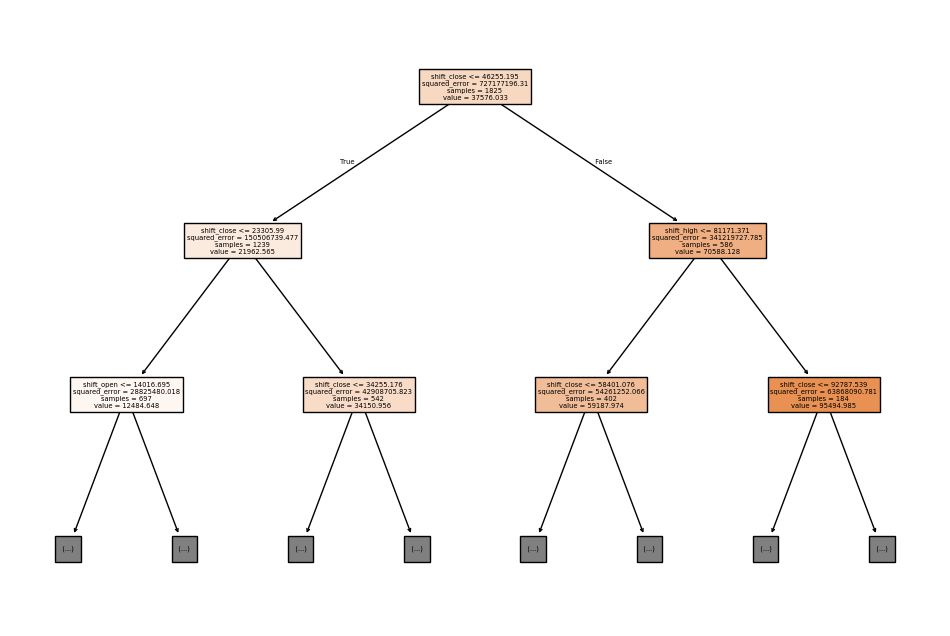

In [96]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

dt_model = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_model.fit(X1_train, y1_train)

plt.figure(figsize=(12,8))
plot_tree(dt_model, filled=True, feature_names=X1_train.columns, max_depth=2)
plt.show()


Data Drift (dérive des données)

Tableau de détection de drift (Top 10 variables les plus affectées) :


,feature,p_value,drift_detected
7,ema_99,0.000000,True
6,ema_20,0.000000,True
5,ema_7,0.000000,True
1,high,0.000000,True
22,shift_high,0.000000,True
0,open,0.000000,True
23,shift_low,0.000000,True
2,low,0.000000,True
3,close,0.000000,True
21,shift_open,0.000000,True


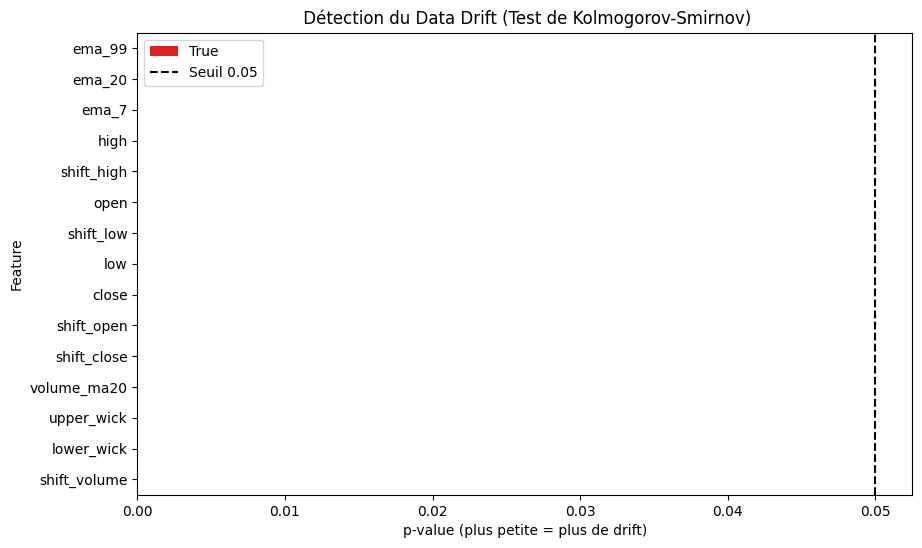


 Zoom sur la variable la plus dérivée : ema_99


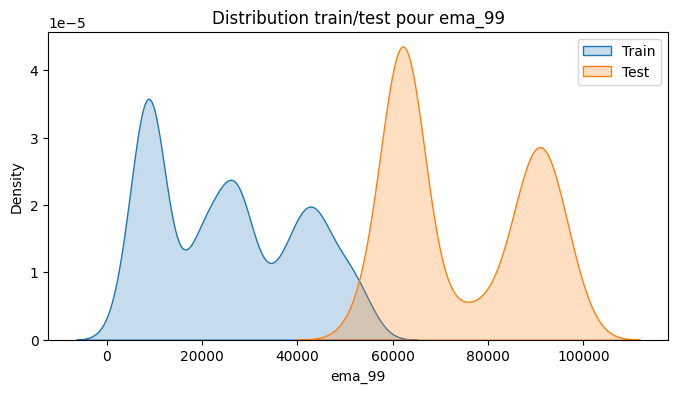

In [97]:
# Détection et visualisation du Data Drift (Kolmogorov-Smirnov)

from scipy.stats import ks_2samp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# 1️ Comparaison statistique entre Train et Test
drift_results = []

for col in features:
    stat, p_value = ks_2samp(X_train[col], X_test[col])
    drift_results.append({"feature": col, "p_value": p_value})

# 2️ Conversion en DataFrame
df_drift = pd.DataFrame(drift_results)
df_drift["drift_detected"] = df_drift["p_value"] < 0.05
df_drift = df_drift.sort_values("p_value")

# 3️ Tableau des résultats
print("Tableau de détection de drift (Top 10 variables les plus affectées) :")
display(df_drift.head(10).style.background_gradient(cmap="coolwarm", subset=["p_value"]))

# 4️ Visualisation graphique avec Seaborn
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_drift.head(15),
    x="p_value", y="feature", hue="drift_detected",
    palette={True: "red", False: "green"}
)
plt.axvline(0.05, color="black", linestyle="--", label="Seuil 0.05")
plt.title(" Détection du Data Drift (Test de Kolmogorov-Smirnov)")
plt.xlabel("p-value (plus petite = plus de drift)")
plt.ylabel("Feature")
plt.legend()
plt.show()

# 5️ Visualisation interactive avec Plotly
fig = px.bar(
    df_drift.sort_values("p_value").head(20),
    x="p_value",
    y="feature",
    color="drift_detected",
    color_discrete_map={True: "crimson", False: "limegreen"},
    orientation="h",
    title="Détection du Data Drift par feature (Kolmogorov-Smirnov)"
)
fig.add_vline(x=0.05, line_dash="dash", line_color="black")
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

# 6️⃣ Zoom automatique sur la variable la plus dérivée
worst_col = df_drift.iloc[0]["feature"]
print(f"\n Zoom sur la variable la plus dérivée : {worst_col}")

plt.figure(figsize=(8,4))
sns.kdeplot(X_train[worst_col], label="Train", fill=True)
sns.kdeplot(X_test[worst_col], label="Test", fill=True)
plt.title(f"Distribution train/test pour {worst_col}")
plt.legend()
plt.show()


Signaux d'achat / vente

In [94]:
# Génération et Visualisation des Signaux d'Achat / Vente

def generate_signals(df):
    """
    Génère des signaux BUY / SELL basés sur RSI, MACD et EMA.
    Args:
        df (pd.DataFrame): données contenant RSI, MACD, EMA7, EMA20
    Returns:
        pd.DataFrame avec colonnes signal_rsi, signal_macd, signal_ema, signal_final
    """
    df = df.copy()

    # --- RSI ---
    df["signal_rsi"] = 0
    df.loc[df["rsi"] < 30, "signal_rsi"] = 1
    df.loc[df["rsi"] > 70, "signal_rsi"] = -1

    # --- MACD ---
    df["signal_macd"] = 0
    df.loc[(df["macd"] > df["macd_signal"]) & (df["macd"].shift(1) <= df["macd_signal"].shift(1)), "signal_macd"] = 1
    df.loc[(df["macd"] < df["macd_signal"]) & (df["macd"].shift(1) >= df["macd_signal"].shift(1)), "signal_macd"] = -1

    # --- EMA ---
    df["signal_ema"] = 0
    df.loc[df["ema_7"] > df["ema_20"], "signal_ema"] = 1
    df.loc[df["ema_7"] < df["ema_20"], "signal_ema"] = -1

    # --- Combinaison finale ---
    df["signal_final"] = df[["signal_rsi", "signal_macd", "signal_ema"]].mean(axis=1)
    df["decision"] = "NEUTRE"
    df.loc[df["signal_final"] > 0.5, "decision"] = "ACHAT"
    df.loc[df["signal_final"] < -0.5, "decision"] = "VENTE"

    return df


# --- Application sur ton DataFrame ---
df_signals = generate_signals(df_grouped)

print("Signaux ajoutés :")
display(df_signals[["date", "close", "rsi", "macd", "macd_signal", "ema_7", "ema_20", "decision"]].tail(10))

# --- Visualisation des signaux sur graphique en chandelier ---
fig = go.Figure()

fig.add_trace(go.Candlestick(
    x=df_signals["date"],
    open=df_signals["open"],
    high=df_signals["high"],
    low=df_signals["low"],
    close=df_signals["close"],
    name="Prix BTC/USDT"
))

# Points d’achat
fig.add_trace(go.Scatter(
    x=df_signals.loc[df_signals["decision"] == "ACHAT", "date"],
    y=df_signals.loc[df_signals["decision"] == "ACHAT", "close"],
    mode="markers",
    marker=dict(color="limegreen", size=10, symbol="triangle-up"),
    name="Signal ACHAT"
))

# Points de vente
fig.add_trace(go.Scatter(
    x=df_signals.loc[df_signals["decision"] == "VENTE", "date"],
    y=df_signals.loc[df_signals["decision"] == "VENTE", "close"],
    mode="markers",
    marker=dict(color="red", size=10, symbol="triangle-down"),
    name="Signal VENTE"
))

fig.update_layout(
    title="Signaux d'achat / vente BTC/USDT basés sur RSI, MACD et EMA",
    xaxis_title="Date",
    yaxis_title="Prix (USDT)",
    xaxis_rangeslider_visible=False,
    template="plotly_dark",
    width=1000,
    height=600
)

fig.show()


Signaux ajoutés :


,date,close,rsi,macd,macd_signal,ema_7,ema_20,decision
2272,2025-06-11,108510.65,58.855513,1441.380623,1409.893745,107610.754143,106230.053081,ACHAT
2273,2025-06-12,105952.01,51.391764,1253.994612,1378.713918,107196.068107,106203.572788,NEUTRE
2274,2025-06-13,105678.00,50.650966,1071.033325,1317.177800,106816.551080,106153.518237,NEUTRE
2275,2025-06-14,105375.99,49.798915,891.390113,1232.020262,106456.410810,106079.467928,NEUTRE
2276,2025-06-15,104824.01,48.202898,696.453123,1124.906834,106048.310608,105959.900507,NEUTRE
2277,2025-06-16,108563.27,58.018605,834.076471,1066.740762,106677.050456,106207.840458,NEUTRE
2278,2025-06-17,104581.99,47.662142,614.800901,976.352790,106153.285342,106052.997558,NEUTRE
2279,2025-06-18,105126.00,49.001722,479.394333,876.961098,105896.464006,105964.712076,NEUTRE
2280,2025-06-19,104350.00,47.147956,305.940248,762.756928,105509.848005,105810.929973,NEUTRE
2281,2025-06-20,103560.70,45.271935,103.592573,630.924057,105022.561004,105596.622357,NEUTRE


Machine Learning FLUO 

In [95]:
# Visualisation des performances

# Prédictions sur le jeu de test

# --- Harmonisation des colonnes entre train et test ---
expected_features = model.feature_names_in_
X1_test = X1_test.reindex(columns=expected_features, fill_value=0)

y_pred = model.predict(X1_test)

# 1. Prédictions vs Valeurs réelles
fig1 = px.scatter(
    x=y1_test, y=y_pred,
    title="Prédictions vs Valeurs réelles (Random Forest)",
    labels={'x': "Valeurs réelles (y_test)", 'y': "Valeurs prédites (y_pred)"},
    color=(y_pred - y1_test),
    color_continuous_scale="Viridis"
)
fig1.add_shape(type="line", x0=min(y1_test), y0=min(y1_test), x1=max(y1_test), y1=max(y1_test),
               line=dict(color="white", dash="dash"))
fig1.update_layout(template="plotly_dark")
fig1.show()

# 2. Résidus colorés ("fluo")
residuals = y1_test - y_pred
fig2 = px.scatter(
    x=y_pred, y=residuals,
    color=np.abs(residuals),
    color_continuous_scale="Plasma",
    title="Résidus (valeurs réelles - prédites)",
    labels={'x': "Valeurs prédites", 'y': "Résidus"}
)
fig2.add_hline(y=0, line_dash="dash", line_color="white")
fig2.update_layout(template="plotly_dark")
fig2.show()

# 3. Importance des features
importances = model.feature_importances_
feat_imp = pd.DataFrame({"Feature": X1.columns, "Importance": importances})
feat_imp = feat_imp.sort_values(by="Importance", ascending=False)

fig3 = px.bar(
    feat_imp.head(15),
    x="Importance", y="Feature",
    orientation="h",
    color="Importance",
    color_continuous_scale="Turbo",
    title="Importance des variables (Top 15)",
)
fig3.update_layout(template="plotly_dark", yaxis={'categoryorder':'total ascending'})
fig3.show()

# 4. Indicateurs de performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(y1_test, y_pred))
mae = mean_absolute_error(y1_test, y_pred)
r2 = r2_score(y1_test, y_pred)

print(f" RMSE : {rmse:.2f}")
print(f" MAE  : {mae:.2f}")
print(f" R²    : {r2:.3f}")


 RMSE : 17991.34
 MAE  : 12448.81
 R²    : 0.542
